# 01 – Feature Engineering with SQL

## Purpose
This notebook loads raw CSV data into SQLite and extracts analytical features using SQL queries:
- **Error rates**: Calculate error rates per firmware version
- **RMA analysis**: Identify high-return versions
- **Spike detection**: Find abnormal error patterns
- **Pre/post comparisons**: Regression detection
- **Stability curves**: Time-series error trends

## Inputs
- `data/Raw/device_events.csv`
- `data/Raw/firmware_releases.csv`
- `data/Raw/support_tickets.csv`

## Outputs
- SQLite database (`db/roku_telemetry.db`)
- 6 feature datasets in `data/Processed/`

---

## 1. Setup & Configuration

In [16]:
# Standard imports
import pandas as pd
import numpy as np
import sqlite3
import sys
from pathlib import Path

# Add project root to path
current_dir = Path.cwd()
project_root = current_dir.parents[0] if current_dir.name == "notebooks" else current_dir
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.config import (
    RAW_DATA_DIR, 
    PROCESSED_DATA_DIR, 
    DB_PATH,
    DEVICE_EVENTS_PATH,
    FIRMWARE_RELEASES_PATH,
    SUPPORT_TICKETS_PATH,
    RANDOM_SEED
)

np.random.seed(RANDOM_SEED)

print(f"✅ Configuration loaded")
print(f"📁 Raw data: {RAW_DATA_DIR}")
print(f"📁 Processed data: {PROCESSED_DATA_DIR}")
print(f"🗄️  Database: {DB_PATH}")

✅ Configuration loaded
📁 Raw data: /Users/hc/Documents/projects/roku-patch-stability-analytics/data/Raw
📁 Processed data: /Users/hc/Documents/projects/roku-patch-stability-analytics/data/Processed
🗄️  Database: /Users/hc/Documents/projects/roku-patch-stability-analytics/db/roku_telemetry.db


## 2. Load Raw Data from CSV

In [17]:
# Load raw telemetry data
device_events = pd.read_csv(DEVICE_EVENTS_PATH)
firmware_releases = pd.read_csv(FIRMWARE_RELEASES_PATH)
support_tickets = pd.read_csv(SUPPORT_TICKETS_PATH)

print(f"✅ Loaded data:")
print(f"   - Device events: {len(device_events):,} rows")
print(f"   - Firmware releases: {len(firmware_releases):,} rows")
print(f"   - Support tickets: {len(support_tickets):,} rows")

device_events.head()

✅ Loaded data:
   - Device events: 48,615 rows
   - Firmware releases: 1,000 rows
   - Support tickets: 2,000 rows


,device_id,firmware_version,timestamp,error_code,severity,model,region
0,DEV_0328,10.0.1,2024-03-02 00:00:00,ERR_NETWORK_101,low,Roku Ultra,NaN
1,DEV_0420,10.0.1,2024-03-08 00:00:00,ERR_STREAM_101,high,Roku Streaming Stick+,LATAM
2,DEV_0463,10.0.1,2024-02-26 00:00:00,ERR_NETWORK_107,high,Roku Ultra,EU
3,DEV_0179,10.0.1,2024-02-16 00:00:00,ERR_UPDATE_104,low,Roku Ultra,LATAM
4,DEV_0338,10.0.1,2024-01-24 00:00:00,ERR_CRASH_104,low,Roku Premiere,LATAM


## 3. Load Data into SQLite Database

In [18]:
# Connect to database and load tables
conn = sqlite3.connect(DB_PATH)

device_events.to_sql("device_events", conn, if_exists="replace", index=False)
firmware_releases.to_sql("firmware_releases", conn, if_exists="replace", index=False)
support_tickets.to_sql("support_tickets", conn, if_exists="replace", index=False)

conn.commit()

print(f"✅ Data loaded into SQLite database: {DB_PATH}")

✅ Data loaded into SQLite database: /Users/hc/Documents/projects/roku-patch-stability-analytics/db/roku_telemetry.db


In [19]:
# Helper function for cleaner SQL execution
def q(sql):
    """Execute SQL query and return pandas DataFrame"""
    return pd.read_sql_query(sql, conn)

## 4. Data Validation

Quick sanity checks on loaded data.

In [20]:
# Verify row counts
q("""
SELECT 'device_events' AS table_name, COUNT(*) AS row_count FROM device_events
UNION ALL
SELECT 'firmware_releases', COUNT(*) FROM firmware_releases
UNION ALL
SELECT 'support_tickets', COUNT(*) FROM support_tickets;
""")

,table_name,row_count
0,device_events,48615
1,firmware_releases,1000
2,support_tickets,2000


In [21]:
# Check data cardinality
q("""
SELECT
    COUNT(DISTINCT device_id) AS device_count,
    COUNT(DISTINCT error_code) AS error_code_count,
    COUNT(DISTINCT severity) AS severity_count,
    COUNT(DISTINCT firmware_version) AS firmware_count
FROM device_events;
""")

,device_count,error_code_count,severity_count,firmware_count
0,500,50,4,1000


## 5. Feature Engineering - Error Rates by Firmware

In [22]:
error_rates_df = q("""
WITH device_base AS (
    SELECT COUNT(DISTINCT device_id) AS total_devices
    FROM device_events
),
errors_by_fw AS (
    SELECT firmware_version, COUNT(*) AS error_events
    FROM device_events
    GROUP BY firmware_version
)
SELECT
    e.firmware_version,
    e.error_events,
    ROUND(1.0 * e.error_events / d.total_devices * 10000, 2) AS error_rate_per_10k
FROM errors_by_fw e
CROSS JOIN device_base d
ORDER BY error_rate_per_10k DESC;
""")

print(f"✅ Generated error rates for {len(error_rates_df)} firmware versions")
error_rates_df.head(10)

✅ Generated error rates for 1000 firmware versions



,firmware_version,error_events,error_rate_per_10k
0,10.71.1,110,2200.0
1,10.168.5,101,2020.0
2,10.177.2,101,2020.0
3,10.18.3,99,1980.0
4,10.117.1,96,1920.0
5,10.62.5,95,1900.0
6,10.41.8,93,1860.0
7,10.74.12,92,1840.0
8,10.113.3,90,1800.0
9,10.26.0,90,1800.0


## 6. RMA Analysis by Error Code & Firmware

In [23]:
# RMA rates by error code
rma_by_error_df = q("""
SELECT
    error_code,
    COUNT(*) AS ticket_count,
    SUM(rma_issued) AS rma_count,
    ROUND(1.0 * SUM(rma_issued) / COUNT(*), 3) AS rma_rate
FROM support_tickets
GROUP BY error_code
ORDER BY rma_rate DESC;
""")

print(f"✅ RMA analysis for {len(rma_by_error_df)} error codes")
rma_by_error_df.head()

✅ RMA analysis for 50 error codes


,error_code,ticket_count,rma_count,rma_rate
0,ERR_BOOT_107,35,12,0.343
1,ERR_UPDATE_101,35,10,0.286
2,ERR_UPDATE_100,43,11,0.256
3,ERR_STREAM_106,43,10,0.233
4,ERR_NETWORK_103,31,7,0.226


In [24]:
# RMA rates by firmware version
rma_by_firmware_df = q("""
WITH ticket_events AS (
    SELECT
        t.ticket_id,
        t.device_id,
        t.error_code,
        t.rma_issued,
        t.created_at,
        e.firmware_version
    FROM support_tickets t
    JOIN device_events e 
      ON t.device_id = e.device_id 
     AND t.error_code = e.error_code
     AND e.timestamp <= t.created_at
)
SELECT
    firmware_version,
    COUNT(*) AS tickets,
    SUM(rma_issued) AS rmas,
    ROUND(1.0 * SUM(rma_issued) / COUNT(*), 3) AS rma_rate
FROM ticket_events
GROUP BY firmware_version
ORDER BY rma_rate DESC;
""")

print(f"✅ RMA analysis for {len(rma_by_firmware_df)} firmware versions")
rma_by_firmware_df.head()

✅ RMA analysis for 951 firmware versions


,firmware_version,tickets,rmas,rma_rate
0,10.99.2,1,1,1.0
1,10.98.0,1,1,1.0
2,10.91.2,4,4,1.0
3,10.22.5,1,1,1.0
4,10.206.0,1,1,1.0


## 7. Spike Detection (7-Day Trailing Average)

Identifies error spikes where daily error count exceeds 1.5x the 7-day trailing average.

In [25]:
spikes_df = q("""
WITH daily AS (
    SELECT 
        error_code,
        DATE(timestamp) AS day,
        COUNT(*) AS error_count
    FROM device_events
    GROUP BY 1, 2
),
rolled AS (
    SELECT
        error_code,
        day,
        error_count,
        AVG(error_count) OVER (
            PARTITION BY error_code
            ORDER BY day
            ROWS BETWEEN 7 PRECEDING AND 1 PRECEDING
        ) AS trailing_7d_avg
    FROM daily
)
SELECT
    error_code,
    day,
    error_count,
    trailing_7d_avg,
    ROUND(CASE 
        WHEN trailing_7d_avg IS NULL THEN NULL
        ELSE 1.0 * error_count / trailing_7d_avg
    END, 2) AS spike_ratio
FROM rolled
WHERE trailing_7d_avg IS NOT NULL
  AND spike_ratio >= 1.5
ORDER BY spike_ratio DESC;
""")

print(f"✅ Detected {len(spikes_df)} error spikes")
spikes_df.head(10)

✅ Detected 1108 error spikes


,error_code,day,error_count,trailing_7d_avg,spike_ratio
0,ERR_BOOT_100,2037-02-04,3,1.0,3.0
1,ERR_BOOT_101,2079-11-11,3,1.0,3.0
2,ERR_BOOT_105,2029-05-22,3,1.0,3.0
3,ERR_BOOT_109,2074-06-08,3,1.0,3.0
4,ERR_CRASH_101,2041-01-09,3,1.0,3.0
5,ERR_CRASH_102,2045-10-25,3,1.0,3.0
6,ERR_NETWORK_105,2051-09-20,3,1.0,3.0
7,ERR_NETWORK_108,2058-12-20,3,1.0,3.0
8,ERR_STREAM_107,2049-05-24,3,1.0,3.0
9,ERR_STREAM_107,2086-09-22,3,1.0,3.0


## 8. Pre/Post Release Regression Analysis

Compares error rates 14 days before vs. 14 days after each firmware release to identify regressions.

In [11]:
pre_post_df = q("""
WITH pre_post AS (
    SELECT
        fr.firmware_version AS release_version,
        de.error_code,
        CASE
            WHEN date(de.timestamp) BETWEEN date(fr.release_date, '-14 days')
                                        AND date(fr.release_date, '-1 day')
                THEN 'pre'
            WHEN date(de.timestamp) BETWEEN date(fr.release_date)
                                        AND date(fr.release_date, '+14 days')
                THEN 'post'
        END AS period
    FROM firmware_releases fr
    JOIN device_events de
      ON date(de.timestamp) BETWEEN date(fr.release_date, '-14 days')
                                AND date(fr.release_date, '+14 days')
),
agg AS (
    SELECT
        release_version,
        error_code,
        SUM(CASE WHEN period = 'pre'  THEN 1 ELSE 0 END) AS pre_errors,
        SUM(CASE WHEN period = 'post' THEN 1 ELSE 0 END) AS post_errors
    FROM pre_post
    GROUP BY release_version, error_code
)
SELECT
    release_version,
    error_code,
    pre_errors,
    post_errors,
    (post_errors - pre_errors) AS delta_errors,
    CASE 
        WHEN pre_errors > 0 
        THEN ROUND(1.0 * post_errors / pre_errors, 2)
        ELSE NULL
    END AS post_pre_ratio
FROM agg
WHERE post_errors >= 50
ORDER BY release_version, error_code;
""")

print(f"✅ Analyzed {len(pre_post_df)} release/error combinations")
pre_post_df.head(10)

✅ Analyzed 0 release/error combinations


,release_version,error_code,pre_errors,post_errors,delta_errors,post_pre_ratio


## 9. Firmware Stability Curves

Tracks error counts over days since release for each firmware version.

In [12]:
stability_df = q("""
SELECT
    e.firmware_version,
    CAST(julianday(e.timestamp) - julianday(r.release_date) AS INT) AS days_since_release,
    COUNT(*) AS error_count
FROM device_events e
JOIN firmware_releases r
  ON e.firmware_version = r.firmware_version
WHERE days_since_release >= 0
GROUP BY 1, 2
ORDER BY 1, 2;
""")

print(f"✅ Generated stability curves: {len(stability_df)} data points")
stability_df.head(10)

✅ Generated stability curves: 26674 data points


,firmware_version,days_since_release,error_count
0,10.0.1,0,2
1,10.0.1,1,2
2,10.0.1,2,1
3,10.0.1,3,1
4,10.0.1,4,1
5,10.0.1,5,1
6,10.0.1,7,1
7,10.0.1,8,1
8,10.0.1,9,1
9,10.0.1,13,1


## 10. Export Processed Features

In [13]:
# Save all processed datasets
pre_post_df.to_csv(PROCESSED_DATA_DIR / "pre_post_errors.csv", index=False)
stability_df.to_csv(PROCESSED_DATA_DIR / "stability_curves.csv", index=False)
spikes_df.to_csv(PROCESSED_DATA_DIR / "error_spikes.csv", index=False)
error_rates_df.to_csv(PROCESSED_DATA_DIR / "error_rates.csv", index=False)
rma_by_firmware_df.to_csv(PROCESSED_DATA_DIR / "rma_by_firmware.csv", index=False)
rma_by_error_df.to_csv(PROCESSED_DATA_DIR / "rma_by_error.csv", index=False)

print(f"✅ Exported 6 processed feature datasets to {PROCESSED_DATA_DIR}")
print(f"\n📊 Summary:")
print(f"   - pre_post_errors.csv: {len(pre_post_df):,} rows")
print(f"   - stability_curves.csv: {len(stability_df):,} rows")
print(f"   - error_spikes.csv: {len(spikes_df):,} rows")
print(f"   - error_rates.csv: {len(error_rates_df):,} rows")
print(f"   - rma_by_firmware.csv: {len(rma_by_firmware_df):,} rows")
print(f"   - rma_by_error.csv: {len(rma_by_error_df):,} rows")

✅ Exported 6 processed feature datasets to /Users/hc/Documents/projects/roku-patch-stability-analytics/data/Processed

📊 Summary:
   - pre_post_errors.csv: 0 rows
   - stability_curves.csv: 26,674 rows
   - error_spikes.csv: 1,108 rows
   - error_rates.csv: 1,000 rows
   - rma_by_firmware.csv: 951 rows
   - rma_by_error.csv: 50 rows


In [14]:
# Close database connection
conn.close()
print("✅ Database connection closed")

✅ Database connection closed


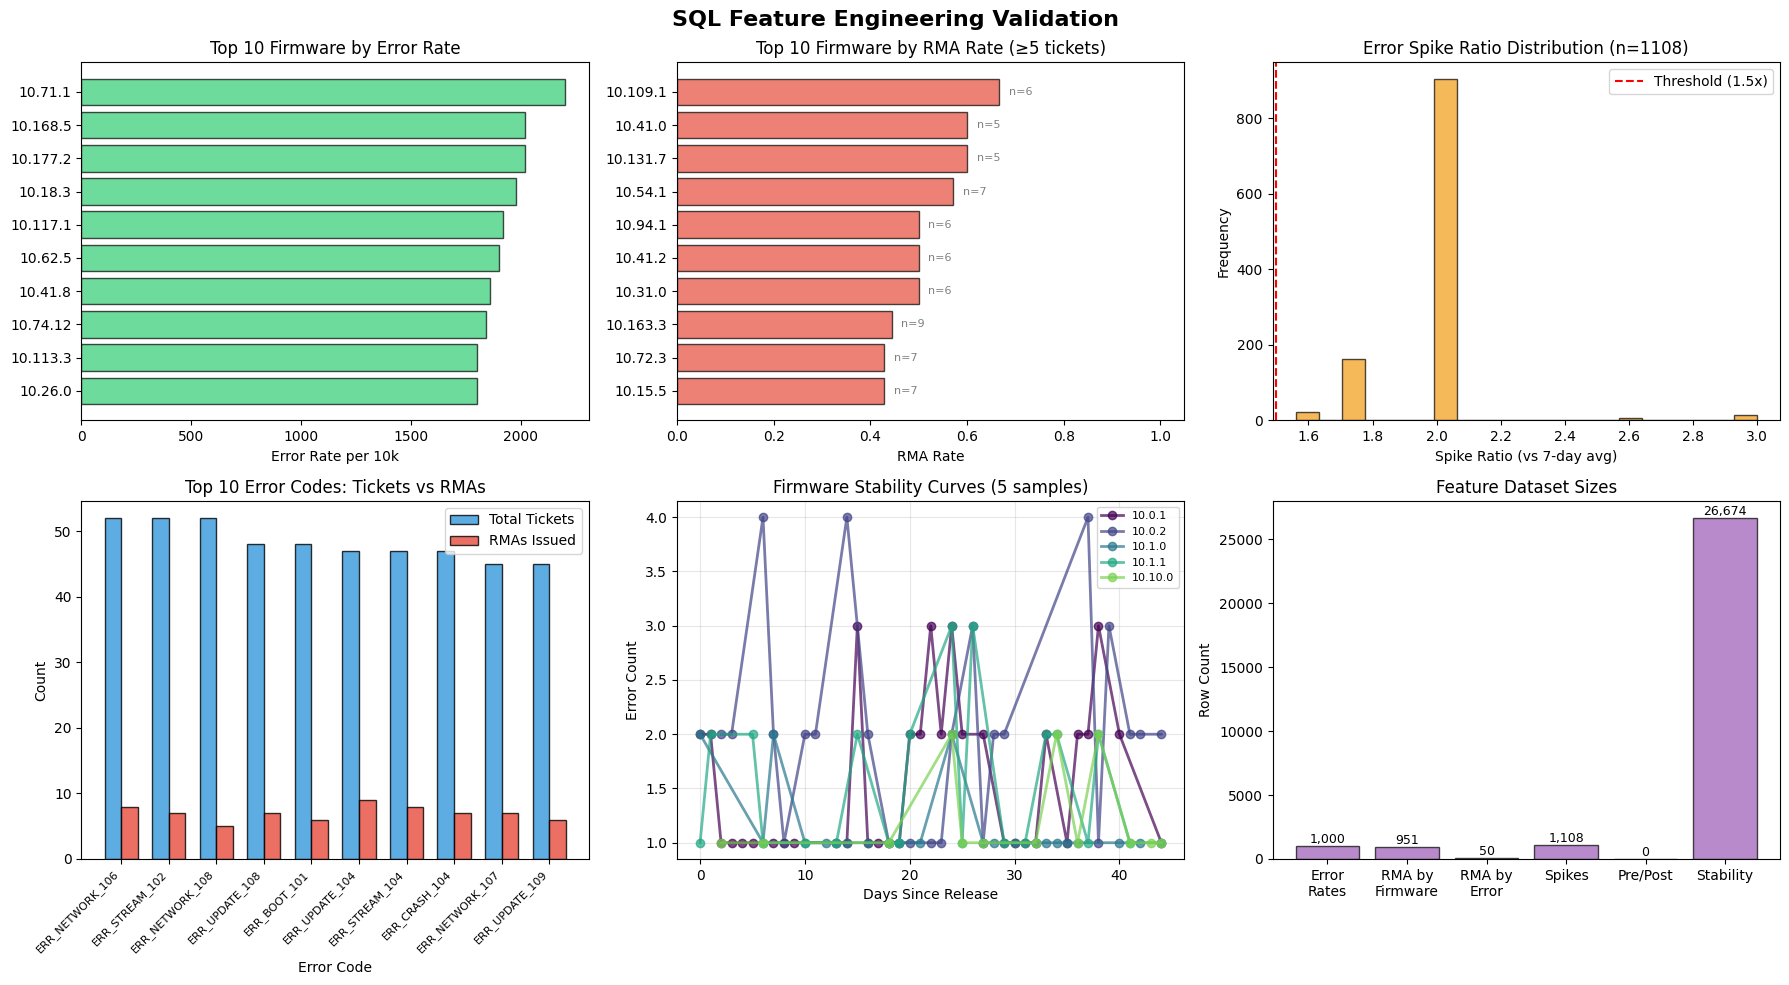


✅ SQL FEATURE EXTRACTION SUMMARY
   📊 Error rates:      1,000 firmware versions
   🔄 RMA by firmware:    951 versions
   ⚠️  RMA by error:       50 error codes
   📈 Spikes detected:  1,108 anomalies
   🔍 Pre/Post pairs:       0 combinations
   📉 Stability data:  26,674 data points


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reload data from saved CSVs if variables are missing (e.g., after kernel restart)
if 'error_rates_df' not in dir() or error_rates_df is None:
    error_rates_df = pd.read_csv(PROCESSED_DATA_DIR / "error_rates.csv")
if 'rma_by_firmware_df' not in dir() or rma_by_firmware_df is None:
    rma_by_firmware_df = pd.read_csv(PROCESSED_DATA_DIR / "rma_by_firmware.csv")
if 'rma_by_error_df' not in dir() or rma_by_error_df is None:
    rma_by_error_df = pd.read_csv(PROCESSED_DATA_DIR / "rma_by_error.csv")
if 'spikes_df' not in dir() or spikes_df is None:
    spikes_df = pd.read_csv(PROCESSED_DATA_DIR / "error_spikes.csv")
if 'pre_post_df' not in dir() or pre_post_df is None:
    pre_post_df = pd.read_csv(PROCESSED_DATA_DIR / "pre_post_errors.csv")
if 'stability_df' not in dir() or stability_df is None:
    stability_df = pd.read_csv(PROCESSED_DATA_DIR / "stability_curves.csv")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('SQL Feature Engineering Validation', fontsize=16, fontweight='bold')

# 1. Top 10 firmware versions by error rate
top_errors = error_rates_df.nlargest(10, 'error_rate_per_10k')
axes[0, 0].barh(top_errors['firmware_version'].astype(str), top_errors['error_rate_per_10k'], 
                edgecolor='black', alpha=0.7, color='#2ecc71')
axes[0, 0].set_title('Top 10 Firmware by Error Rate')
axes[0, 0].set_xlabel('Error Rate per 10k')
axes[0, 0].invert_yaxis()

# 2. RMA rates by firmware - filter to meaningful sample sizes
if len(rma_by_firmware_df) > 0 and 'rma_rate' in rma_by_firmware_df.columns:
    # Only show firmware with at least 5 tickets for meaningful RMA rates
    meaningful_rma = rma_by_firmware_df[rma_by_firmware_df['tickets'] >= 5].copy()
    if len(meaningful_rma) > 0:
        top_rma = meaningful_rma.nlargest(10, 'rma_rate')
        bars = axes[0, 1].barh(top_rma['firmware_version'].astype(str), top_rma['rma_rate'], 
                        edgecolor='black', alpha=0.7, color='#e74c3c')
        axes[0, 1].set_xlim(0, 1.05)  # Set proper x-axis limit for rates 0-1
        axes[0, 1].invert_yaxis()
        # Add ticket count annotations
        for bar, tickets in zip(bars, top_rma['tickets']):
            axes[0, 1].text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, 
                           f'n={tickets}', va='center', fontsize=8, color='gray')
        axes[0, 1].set_title('Top 10 Firmware by RMA Rate (≥5 tickets)')
    else:
        # Fall back to top by ticket volume if no meaningful rates
        top_tickets = rma_by_firmware_df.nlargest(10, 'tickets')
        axes[0, 1].barh(top_tickets['firmware_version'].astype(str), top_tickets['tickets'], 
                        edgecolor='black', alpha=0.7, color='#e74c3c')
        axes[0, 1].invert_yaxis()
        axes[0, 1].set_title('Top 10 Firmware by Ticket Volume')
        axes[0, 1].set_xlabel('Ticket Count')
else:
    axes[0, 1].text(0.5, 0.5, 'No RMA data available', ha='center', va='center', 
                    transform=axes[0, 1].transAxes, fontsize=12)
    axes[0, 1].set_title('RMA Analysis')
axes[0, 1].set_xlabel('RMA Rate')

# 3. Error spike distribution
if len(spikes_df) > 0 and 'spike_ratio' in spikes_df.columns:
    axes[0, 2].hist(spikes_df['spike_ratio'], bins=20, edgecolor='black', alpha=0.7, color='#f39c12')
    axes[0, 2].set_title(f'Error Spike Ratio Distribution (n={len(spikes_df)})')
    axes[0, 2].set_xlabel('Spike Ratio (vs 7-day avg)')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].axvline(x=1.5, color='red', linestyle='--', label='Threshold (1.5x)')
    axes[0, 2].legend()
else:
    axes[0, 2].text(0.5, 0.5, 'No spikes detected', ha='center', va='center', 
                    transform=axes[0, 2].transAxes, fontsize=12)
    axes[0, 2].set_title('Error Spike Distribution')

# 4. Pre vs Post error comparison (grouped bar chart)
if len(pre_post_df) > 0 and 'post_pre_ratio' in pre_post_df.columns:
    # Filter to valid ratios and get top regressions
    valid_ratios = pre_post_df[pre_post_df['post_pre_ratio'].notna()]
    sample = valid_ratios.nlargest(10, 'post_pre_ratio')
    x = np.arange(len(sample))
    width = 0.35
    axes[1, 0].bar(x - width/2, sample['pre_errors'], width, alpha=0.8, label='Pre-release', 
                   edgecolor='black', color='#3498db')
    axes[1, 0].bar(x + width/2, sample['post_errors'], width, alpha=0.8, label='Post-release', 
                   edgecolor='black', color='#e74c3c')
    axes[1, 0].set_title('Top 10 Regressions: Pre vs Post Errors')
    axes[1, 0].set_xlabel('Release/Error Combination')
    axes[1, 0].set_ylabel('Error Count')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels([f"{r['release_version'][:8]}" for _, r in sample.iterrows()], 
                               rotation=45, ha='right', fontsize=8)
    axes[1, 0].legend()
else:
    # Show RMA by error code as alternative visualization
    if len(rma_by_error_df) > 0:
        top_errors = rma_by_error_df.nlargest(10, 'ticket_count')
        x = np.arange(len(top_errors))
        width = 0.35
        axes[1, 0].bar(x - width/2, top_errors['ticket_count'], width, alpha=0.8, 
                       label='Total Tickets', edgecolor='black', color='#3498db')
        axes[1, 0].bar(x + width/2, top_errors['rma_count'], width, alpha=0.8, 
                       label='RMAs Issued', edgecolor='black', color='#e74c3c')
        axes[1, 0].set_title('Top 10 Error Codes: Tickets vs RMAs')
        axes[1, 0].set_xlabel('Error Code')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels(top_errors['error_code'], rotation=45, ha='right', fontsize=8)
        axes[1, 0].legend()
    else:
        axes[1, 0].text(0.5, 0.5, 'No pre/post or RMA data available\n(Date ranges may not overlap)', 
                        ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=10)
        axes[1, 0].set_title('Pre/Post Release Analysis')

# 5. Stability curves (sample 5 firmware versions)
if len(stability_df) > 0:
    sample_versions = stability_df['firmware_version'].unique()[:5]
    colors = plt.cm.viridis(np.linspace(0, 0.8, len(sample_versions)))
    for i, version in enumerate(sample_versions):
        version_data = stability_df[stability_df['firmware_version'] == version].sort_values('days_since_release')
        axes[1, 1].plot(version_data['days_since_release'], version_data['error_count'], 
                       marker='o', alpha=0.7, linewidth=2, color=colors[i], label=str(version)[:12])
    axes[1, 1].set_title('Firmware Stability Curves (5 samples)')
    axes[1, 1].set_xlabel('Days Since Release')
    axes[1, 1].set_ylabel('Error Count')
    axes[1, 1].legend(fontsize=8, loc='upper right')
    axes[1, 1].grid(alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'No stability data', ha='center', va='center', 
                    transform=axes[1, 1].transAxes)

# 6. Dataset size summary
dataset_sizes = {
    'Error\nRates': len(error_rates_df),
    'RMA by\nFirmware': len(rma_by_firmware_df),
    'RMA by\nError': len(rma_by_error_df),
    'Spikes': len(spikes_df),
    'Pre/Post': len(pre_post_df),
    'Stability': len(stability_df)
}
bars = axes[1, 2].bar(dataset_sizes.keys(), dataset_sizes.values(), edgecolor='black', alpha=0.7, color='#9b59b6')
axes[1, 2].set_title('Feature Dataset Sizes')
axes[1, 2].set_ylabel('Row Count')
# Add value labels on bars
for bar, val in zip(bars, dataset_sizes.values()):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    f'{val:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✅ SQL FEATURE EXTRACTION SUMMARY")
print("="*60)
print(f"   📊 Error rates:     {len(error_rates_df):>6,} firmware versions")
print(f"   🔄 RMA by firmware: {len(rma_by_firmware_df):>6,} versions")
print(f"   ⚠️  RMA by error:   {len(rma_by_error_df):>6,} error codes")
print(f"   📈 Spikes detected: {len(spikes_df):>6,} anomalies")
print(f"   🔍 Pre/Post pairs:  {len(pre_post_df):>6,} combinations")
print(f"   📉 Stability data:  {len(stability_df):>6,} data points")
print("="*60)